# Imports

In [162]:
import re

import country_converter as coco
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

# Loading the data

In [163]:
df = pd.read_csv("../../data/stats/stats_processed.csv", sep=";")
df.head(5)

winner_name        loser_name  event_date                method  \
0      ILIA TOPURIA      MAX HOLLOWAY  26/10/2024                KO/TKO   
1   KHAMZAT CHIMAEV  ROBERT WHITTAKER  26/10/2024            Submission   
2  MAGOMED ANKALAEV  ALEKSANDAR RAKIC  26/10/2024  Decision - Unanimous   
3     LERONE MURPHY           DAN IGE  26/10/2024  Decision - Unanimous   
4   SHARA MAGOMEDOV   ARMEN PETROSYAN  26/10/2024                KO/TKO   

   round  time        time_format                     bout_type  \
0    3.0  1:34  5 Rnd (5-5-5-5-5)  UFC Featherweight Title Bout   
1    1.0  3:34  5 Rnd (5-5-5-5-5)             Middleweight Bout   
2    3.0  5:00      3 Rnd (5-5-5)        Light Heavyweight Bout   
3    3.0  5:00      3 Rnd (5-5-5)            Featherweight Bout   
4    2.0  4:52      3 Rnd (5-5-5)             Middleweight Bout   

                      event_name                              event_location  \
0  UFC 308: Topuria vs. Holloway  Abu Dhabi, Abu Dhabi, United Arab Emirates   
1  UFC 308: Topuria vs. Holloway  Abu Dhabi, Abu Dhabi, United Arab Emirates   
2  UFC 308: Topuria vs. Holloway  Abu Dhabi, Abu Dhabi, United Arab Emirates   
3  UFC 308: Topuria vs. Holloway  Abu Dhabi, Abu Dhabi, United Arab Emirates   
4  UFC 308: Topuria vs. Holloway  Abu Dhabi, Abu Dhabi, United Arab Emirates   

   ... delta_height delta_reach delta_slpm_cs  delta_str_acc_cs  \
0  ...       -10.16        0.00         -4.76              -1.0   
1  ...         5.08        5.08          4.51              32.0   
2  ...        -2.54       -7.62         -0.82               1.0   
3  ...         5.08        5.08         -1.09              -4.0   
4  ...          NaN         NaN           NaN               NaN   

   delta_sapm_cs  delta_str_def_cs  delta_td_avg_cs  delta_td_acc_cs  \
0          -2.71               8.0             4.04            -16.0   
1          -3.34               6.0             4.24             48.0   
2          -0.45              13.0             0.43              8.0   
3          -1.29               5.0            -0.81              6.0   
4            NaN               NaN              NaN              NaN   

   delta_td_def_cs  delta_sub_avg_cs  
0             16.0               3.9  
1            -84.0               3.1  
2             -5.0              -0.2  
3            -18.0               0.4  
4              NaN               NaN  

[5 rows x 42 columns]

# Explaining features

The features (columns) break down into 2 categories:
* **Categorical features**: Categorical features contain general fight/athlete data like: Fighters' names, nicknames, date of the event, location, number of rounds, time format, etc. Categorical features do not start with prefix `delta`, i.e. all numerical features start with prefix `delta`, the rest are categorical.
* **Numerical features**: These features contain all possible statistical details of the fight. Some of these are: The number of strikes landed, the number of significant strikes landed, the number of submissions attempted, the percentage ratio of the strikes that were landed to the head, the percentage ratio of the strikes that were landed in clinch position, etc. The numerical features, as already mentioned, can be identified by their prefix `delta`.

**Note:** Delta features can be interpreted as follows:<br>
`Delta` - is the difference between two values or metrics, often used to quantify change between different groups.<br>
So in our case `delta_feature_x` is the difference between **the winner's** `feature_x` and **the loser's** `feature_x`. <br><br>For example: <br>
There's `winner_total_strikes_landed` and `loser_total_strikes_landed`.<br>
> `delta_total_strikes_landed` = `winner_total_strikes_landed` - `loser_total_strikes_landed`. <br>

If the value of delta is *positive*, that means the **winner's** performance in that partical feature is **higher**, if the value is *negative*, it means the winner's contribution in that feature was lower compared to loser's, if it *equals 0*, it means the contribution from the winner and loser was **equal**.

* `winner_name`          - The name of the winner of the fight: ('ILIA TOPURIA', 'KHAMZAT CHIMAEV', etc.)
* `loser_name`           - The name of the loser of the fight: ('LERONE MURPHY', 'GEOFF NEAL', etc.)
* `event_date`           - The date of when event took place: ('26/10/2024', '19/10/2024', etc.)
* `winner_nickname`      - The nickname of the winner of the fight: ('El Matador', 'Borz', etc.)
* `loser_nickname`       - The nickname of the loser of the fight: ('Blessed', 'The Reaper', etc.)
* `method`               - The method of victory: ('KO/TKO', 'Submission', Decision - Unanimous', 'Decision - Split', etc.)
* `round`                - The round in which the victory was gained: ('3', '5', '1', etc.)
* `time`                 - The time of the round in which the victory was gained: ('1:34', '3:34', etc.)
* `time_format`          - Time format of the fight and how many rounds: ('5 Rnd (5-5-5-5-5)', '3 Rnd (5-5-5)', etc.)
* `referee`              - The name of the referee: ('Marc Goddard', 'Jason Herzog', etc.)
* `details`              - The details of the victory: ('Punch to Head At Distance', 'Rear Naked Choke', scorecards, etc.)
* `bout_type`            - Bout type: ('UFC Featherweight Title Bout', 'Middleweight Bout', 'Light Heavyweight Bout', etc.)
* `bonus`                - The bonus that the fight got: ('Performance of the night', 'knockout of the night', etc.)
* `event_name`           - The name of the event: ('UFC 308: Topuria vs. Holloway', 'UFC Fight Night: Hernandez vs. Pereira')
* `event_location`       - The location of the event: ('Las Vegas, Nevada, USA', 'Paris, Ile-de-France, France', etc)
* `winner_stance`        - Winner's fighting stance: ('Orthodox', 'Southpaw', etc.)
* `loser_stance`         - Loser's fighting stance: ('Switch', 'Southpaw', etc.)
* `winner`               - The fighter of which corner won: ('Red', 'Blue', etc.)
* `delta_KD`             - The delta difference in landed Knockdowns by strikes: (1,  0, -1)
* `delta_sig_str_pct`    - The delta difference in landed significant strikes in %: (14, -25,  3,)
* `delta_total_str_pct`  - The delta difference in landed total strikes in %: (significant and insignificant) : (14, -25,  3,)
* `delta_TD_pct`         - The delta difference in landed takedowns in %: (14, -25,  3,)
* `delta_sub_att`        - The delta difference in submission attempts: 
* `delta_rev`            - The delta difference in wrestling reversals (where a fighter reverses a disadvantageous position into advantageous). 
* `delta_ctrl`           - The delta difference in the fighter's control of the fight, in seconds
* `delta_sig_str_head_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the head in %
* `delta_sig_str_body_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the body in %
* `delta_sig_str_leg_acc_pct`  - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes to the leg in %
* `delta_sig_str_distance_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the distance in % 
* `delta_sig_str_clinch_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the clinch in % 
* `delta_sig_str_ground_acc_pct` - The delta difference in accuracy (fraction of landed out of the total thrown) of landing significant strikes from the ground in % 
* `delta_sig_str_head_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the head in %
* `delta_sig_str_body_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the body in %
* `delta_sig_str_leg_tar_pct` - The delta difference in contribution (fraction of strikes that were landed on the specified target out of the total 100% pool of 3 possible targets: head, body, legs) of significant strikes to the leg in %
* `delta_sig_str_distance_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from the distance in %
* `delta_sig_str_clinch_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from clinch in %
* `delta_sig_str_ground_pos_pct` - The delta difference in contribution (fraction of strikes that were landed from the specified position out of the total 100% pool of 3 possible positions: distance, clinch, ground) of significant strikes from the ground in %
* `delta_height` - The delta difference in fighters' height
* `delta_reach` - The delta difference in fighters' arms reach
* `delta_slpm_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strikes Landed per Minute
* `delta_str_acc_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Striking Accuracy
* `delta_sapm_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strikes Absorbed per Minute
* `delta_str_def_cs` - The delta difference in fighters' total career statistic (computed from all fights) Significant Strike Defence (the % of opponents' strikes that did not land)
* `delta_td_avg_cs` - The delta difference in fighters' total career statistic (computed from all fights) Average Takedowns Landed per 15 minutes
* `delta_td_acc_cs` - The delta difference in fighters' total career statistic (computed from all fights) Takedown Accuracy
* `delta_td_def_cs` - The delta difference in fighters' total career statistic (computed from all fights) Takedown Defense (the % of opponents' TD attempts that did not land)
* `delta_sub_avg_cs` - The delta difference in fighters' total career statistic (computed from all fights) Average Submissions Attempted per 15 minutes
* `delta_striking_dominance` - The delta difference in fighters' striking dominance (number of knockdowns + number of significant strikes landed + number of total strikes landed
* `delta_wrestling_dominance` - The delta difference in fighters' wrestling dominance (number of takedowns landed + number of submission attempts + number of reversals)

# Establishing questions

### Here are a few questions I want to be answered by the end of this notebook:
1. What are the most popular locations where UFC hosts its events?
2. What is the historical average number of UFC events hosted annually?
3. What are the top fight outcomes?
4. Does being in a particular corner contribute to a victory?
5. Does having a specific fighting stance contribute to a victory?
6. What are the main fight tactics contributing to a victory?
7. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?
8. Based on the findings, can we use the information to bet on a fighter?

# EDA

## 1. What are the most popular locations where UFC hosts its events?

### Top countries by # of UFC events

#### Preparing the data

In [164]:
# Dropping duplicates to keep only one event per date
events = df[["event_name", "event_location"]].drop_duplicates()

# Getting the location counts
counts = events["event_location"].value_counts()

# Make 'event_location' a column and rename the 'count' column to 'num_of_events'
top_locations = counts.reset_index().rename(columns={"count": "num_of_events"})
top_locations["country"] = top_locations["event_location"].apply(
    lambda x: x.split(",")[-1].strip()
)
top_locations.head()

event_location  num_of_events  \
0                      Las Vegas, Nevada, USA            245   
1  Abu Dhabi, Abu Dhabi, United Arab Emirates             18   
2             London, England, United Kingdom             15   
3                    Anaheim, California, USA             10   
4              Atlantic City, New Jersey, USA             10   

                country  
0                   USA  
1  United Arab Emirates  
2        United Kingdom  
3                   USA  
4                   USA

In [165]:
top_countries = top_locations.copy()

# Sum by countries
top_countries = (
    top_countries.groupby("country")
    .sum()
    .sort_values(by="num_of_events", ascending=False)
    .reset_index()
)

# Drop column to keep it clean
top_countries.drop(columns=["event_location"], inplace=True)
top_countries.head()

country  num_of_events
0                   USA            502
1                Brazil             40
2                Canada             33
3        United Kingdom             29
4  United Arab Emirates             20

Add ISO3 country codes for plotting in choropleth:

In [166]:
cc = coco.CountryConverter()

# Convert countries to ISO alpha-3 format
top_countries["iso_alpha"] = cc.pandas_convert(
    series=top_countries["country"], to="ISO3"
)

# Change column positions
top_countries = top_countries.iloc[:, [0, 2, 1]]
top_countries.head()

country iso_alpha  num_of_events
0                   USA       USA            502
1                Brazil       BRA             40
2                Canada       CAN             33
3        United Kingdom       GBR             29
4  United Arab Emirates       ARE             20

Let's add a log-scaled version of the counts, as the range between the top 1 and top 2 is huge, and the choropleth gradient color is going to eat away all of the empty 40 - 500 range:

In [167]:
top_countries["log_num_of_events"] = np.log(top_countries["num_of_events"])
top_countries.head()

country iso_alpha  num_of_events  log_num_of_events
0                   USA       USA            502           6.218600
1                Brazil       BRA             40           3.688879
2                Canada       CAN             33           3.496508
3        United Kingdom       GBR             29           3.367296
4  United Arab Emirates       ARE             20           2.995732

#### Plotting (Log version)

We will add the **log-scaled version** of the `num_of_events` feature, as the deviation from the max value *(USA, **501**)* to the rest of the data *(Others, **1-40**)* is extremely large which would lead to choropleth stretching the color scale too much and that would make all of the other (non-USA) countries effectively the same color.

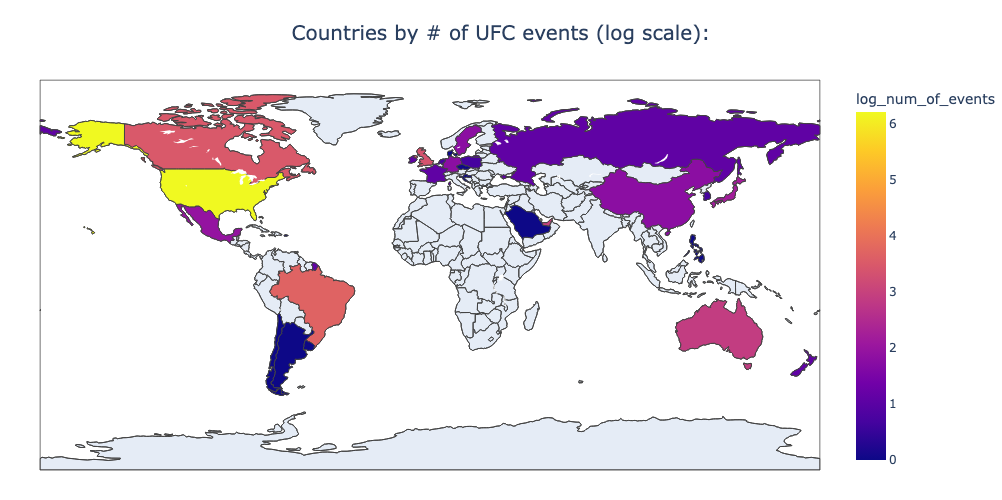

In [168]:
fig = px.choropleth(
    top_countries,  # Plot data
    locations="iso_alpha",  # Use ISO codes as location identifiers
    color="log_num_of_events",  # Coloring based on log scaled num_of_events
    hover_name="country",  # On hover display country
    title="Countries by # of UFC events (log scale):",
    color_continuous_scale=px.colors.sequential.Plasma,
)


# Make bigger and cleaner
fig.update_layout(
    title={"x": 0.5, "font_size": 20},
    height=500,
    width=1000,
    geo=dict(showcountries=True),
    margin=dict(l=30, r=30, t=80, b=30),
)
fig.show()

#### Plotting (Non-log version of the top 20 countries)

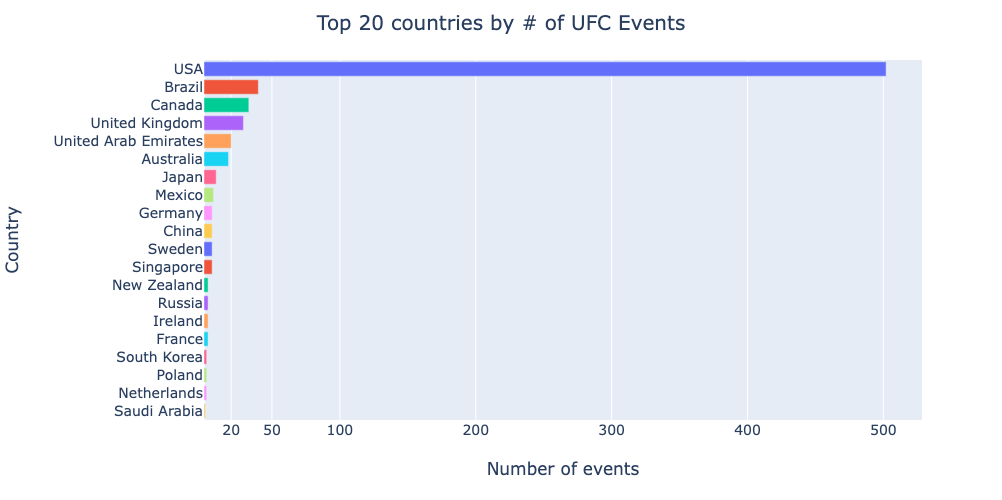

In [169]:
fig = px.bar(top_countries[:20], x="num_of_events", y="country", color="country")

fig.update_layout(
    title={"text": "Top 20 countries by # of UFC Events", "x": 0.5, "font_size": 20},
    font={"size": 14},
    xaxis=dict(
        tickmode="array",
        tickvals=[20, 50, 100, 200, 300, 400, 500],
        title="Number of events",
        title_standoff=25,
    ),
    yaxis=dict(title="Country", title_standoff=40),
    showlegend=False,
    height=500,
)

fig.show()

#### Observations

The homeland to the UFC - The USA is the clear dominant here, followed by Brazil, Canada, the UK, the UAE, Australia, Japan, and others.

The `US is obviously the first` because it is, again, **the homeland**, also I think because **egulation concerns were cleared up** over the years, and overall, the UFC is given a thumbs up for the events, as they **don't have any additional regulatory requirements to comply with**, as they would have to do in hosting events internationally.

That said, by looking at other countries:

* `Brazil is ranked at #2`. And what contributes to that is the **cultural roots of Brazilian jiu-jitsu**, as well as the BJJ grand-master co-founder, the second top country that is the **hometown to the most UFC champions**, and massive fan appetite, like UFC 134 in Rio selling out tickets in 74 minutes and **drawing ~35 million TV viewers**, which accounts for **about x10 the network's average**.
* `Canada sits at #3`. Canada is the **most profitable international market for UFC**, in addition to that: a **massive MMA fan base**, the **popularity of one of the best UFC fighters in history**, who is a Canadian, George St-Pierre, and **strong Canadian regulatory support** after legalization in major provinces make it the #2.
* `The UK at #4` is the **premier MMA hub in Europe** (London, Manchester). **Loyal fanbase**, home to stars like Bisping, Aspinall; **Prime timezone** for capturing European/US crossover audiences and provides fertile ground for local talent development, e.g., Cage Warriors (the UK-based MMA promotion) to UFC pipeline, e.g., Conor McGregor.
* `#5, UAE`. UAE isn't known for huge MMA fanbases, local stars, or notably strong PPV numbers, but it has its own reasons. **Massive government funding** and **infrastructure support**, e.g., they helped UFC build **"Fight Island"** on Yas Island during COVID. It also showcases MMA as a global sport to regional audiences.
* `Australia at #6`. **Australian fans are known to be loud, loyal, and spend-heavy**. Local champions like Alexander Volkanovski, Israel Adesanya, and Robert Whittaker keep demand high.
* `Japan, #7`. Japan was once the **global center of MMA - Pride FC, Shooto, Pancrase**. So UFC tried to capture that market and attempted expansion in the early 2000s, then again with UFC Japan events in the late 2010s. It is known for its **deep martial arts culture and knowledgeable fans**.

But let's take a look at the ratio that it has with respect to the total pool of events in all of the countries:

In [170]:
# Calculate what pct of UFC events take place in the US
usa_pct = (
    top_countries["num_of_events"] / sum(top_countries["num_of_events"]) * 100
).iloc[0]

# Prep the data
pct = pd.DataFrame(
    {"country": ["USA", "Others"], "pct_of_events": [usa_pct, 100 - usa_pct]}
)
pct

country  pct_of_events
0     USA      70.803949
1  Others      29.196051

Plot:

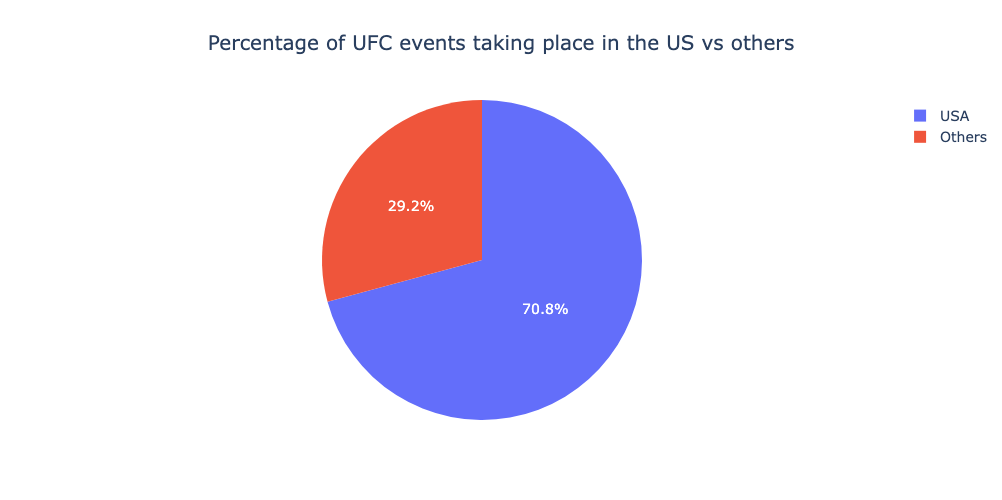

In [171]:
fig = px.pie(
    pct,
    values="pct_of_events",
    names="country",
    title="Percentage of UFC events taking place in the US vs others",
    height=500,
)

fig.update_layout(title={"x": 0.5, "font_size": 20}, font={"size": 14})
fig.update_traces(textfont_size=14, textfont={"color": "white"})

fig.show()

70.8% is the USA only! Alright, but let's take a look at the states:

### Top US states by # of UFC events

#### Preparing the data

Let's prep the data:

In [172]:
# Get a separate df for the top US states
top_states = top_locations[top_locations["country"] == "USA"].copy()

# Extract the states from 'event_location' column
top_states["state"] = top_states["event_location"].apply(
    lambda x: x.split(",")[-2].strip()
)

# Count the number of events per state and sort
top_states = (
    top_states.groupby("state")
    .sum("num_of_events")
    .sort_values(by="num_of_events", ascending=False)
    .reset_index()
)

# A dictionary that maps full state names to their abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "DC": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}

# Mapping to abbreviations
top_states["state_abv"] = top_states["state"].apply(lambda x: us_state_to_abbrev[x])
top_states.head()

state  num_of_events state_abv
0      Nevada            245        NV
1  California             33        CA
2       Texas             25        TX
3     Florida             22        FL
4  New Jersey             22        NJ

#### Plotting

In [173]:
top_states["log_num_of_events"] = np.log(top_states["num_of_events"])

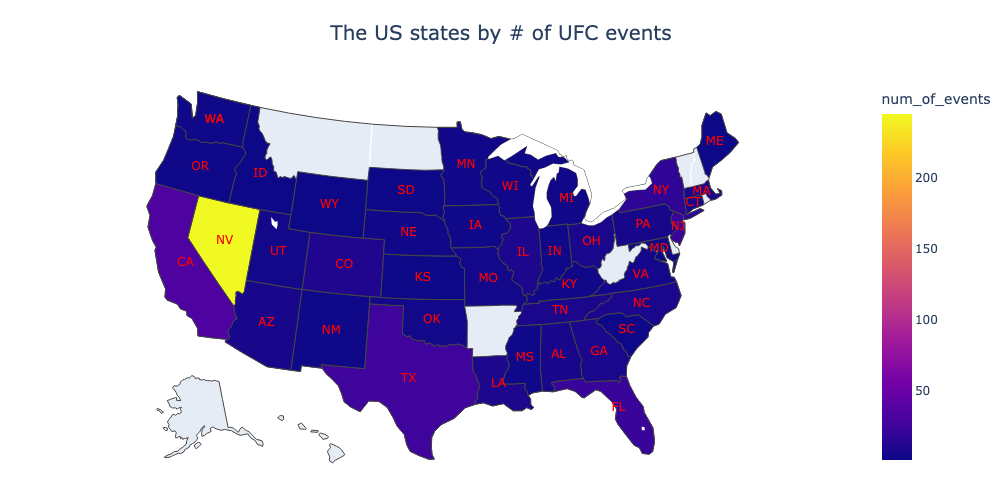

In [174]:
fig = px.choropleth(
    top_states,
    locations="state_abv",
    locationmode="USA-states",
    color="num_of_events",
    scope="usa",
    title="The US states by # of UFC events",
    color_continuous_scale=px.colors.sequential.Plasma,
)

fig.add_scattergeo(
    locations=top_states["state_abv"],
    locationmode="USA-states",
    text=top_states["state_abv"],
    mode="text",
    textfont=dict(size=12, color="red"),
)

# Make bigger and clearer
fig.update_layout(
    title={"x": 0.5, "font_size": 20},
    height=500,
    width=1000,
    geo=dict(showcountries=True),
    margin=dict(l=30, r=30, t=80, b=30),
)
fig.show()

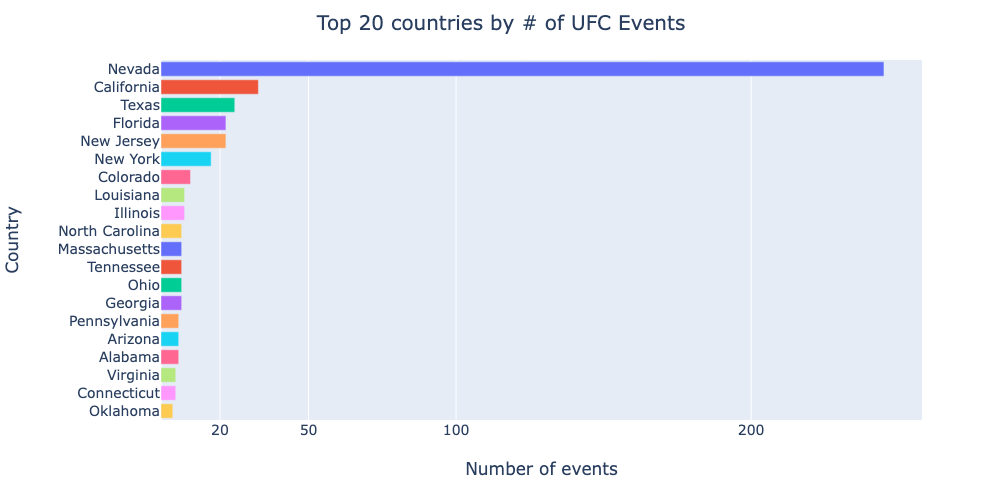

In [175]:
fig = px.bar(top_states[:20], x="num_of_events", y="state", color="state")


fig.update_layout(
    title={"text": "Top 20 countries by # of UFC Events", "x": 0.5, "font_size": 20},
    font={"size": 14},
    xaxis=dict(
        tickmode="array",
        tickvals=[20, 50, 100, 200, 300, 400, 500],
        title="Number of events",
        title_standoff=25,
    ),
    yaxis=dict(title="Country", title_standoff=40),
    showlegend=False,
    height=500,
)
fig.show()

In [176]:
# Calculate what pct of UFC events take place in the US
nevada_pct = (
    top_states["num_of_events"] / sum(top_states["num_of_events"]) * 100
).iloc[0]

# Prep the data
pct = pd.DataFrame(
    {"state": ["Nevada", "Others"], "pct_of_events": [nevada_pct, 100 - nevada_pct]}
)
pct

state  pct_of_events
0  Nevada      48.804781
1  Others      51.195219

Plot:

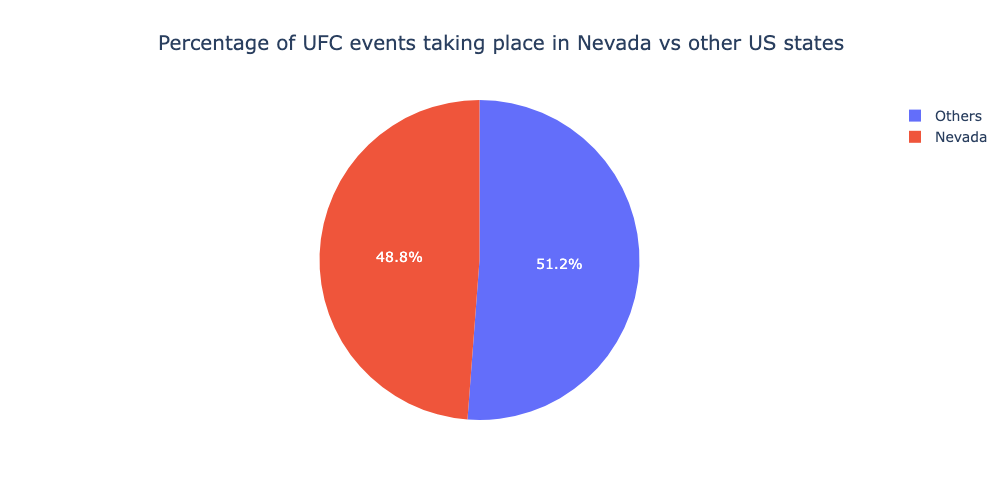

In [177]:
fig = px.pie(
    pct,
    values="pct_of_events",
    names="state",
    title="Percentage of UFC events taking place in Nevada vs other US states",
    height=500,
)

fig.update_layout(title={"x": 0.5, "font_size": 20}, font={"size": 14})
fig.update_traces(textfont_size=14, textfont={"color": "white"})
fig.show()

#### Observations

Let's take a look at a few:
* `Nevada is #1` as Las Vegas is the **fight capital of the world**, it is considered **the home of boxing since** the 1960s (Muhammad Ali, Mike Tyson, Mayweather), and the **biggest fights are usually expected to be in Vegas**. So UFC benefits from Las Vegas's reputation as the world's top fight city. Another reason is that UFC is headquartered in Las Vegas, Nevada, with the **State Athletic Commission** being fighter-friendly and having a high tourism aspect.
* `California is at #2` because it has the **largest population in the U.S.**, has a **huge fanbase** and **ticket demand**, and CA has been long-time **MMA-friendly** since it was the first state to regulate MMA (1990s). Also, LA events are very good for media eyeballs.
* `Texas is at #3` because the **low-friction regulation**, **drug testing**, and **licensing** are usually **easier** there. Additionally, Texas offers stadium-sized venues like **Toyota Center** and a passionate fanbase.
* `Florida is at #4` also because of **low regulatory risk**, and a place for capturing **the Latin/Caribbean fanbase**.
* `New York at #6` is interesting, even though the strictest regulation, UFC literally lobbied 10+ years to legalize MMA, which finally passed in 2016. **NY is prestige & media**, MSG is known as **"the World's most famous arena"**, NY cards are often loaded PPVs.

## 2. What is the historical average amount of UFC fights hosted annually?

### Preparing the data

Dropping duplicates, saving only the annual data, and then sorting it:

In [178]:
# Drop duplicates
events_annually = df[["event_name", "event_date"]].drop_duplicates()
# Extracting annual data
events_annually["event_year"] = pd.to_datetime(
    events_annually["event_date"], dayfirst=True
).dt.year

# Sorting
events_annually_counts = events_annually["event_year"].value_counts(sort=False)
# Making it look more presentable
events_annually_counts = events_annually_counts.reset_index().rename(
    columns={"count": "num_of_events"}
)

# Taking a look
events_annually_counts.head()

event_year  num_of_events
0        2024             36
1        2023             43
2        2022             42
3        2021             43
4        2020             41

Let's plot this:

### Plotting

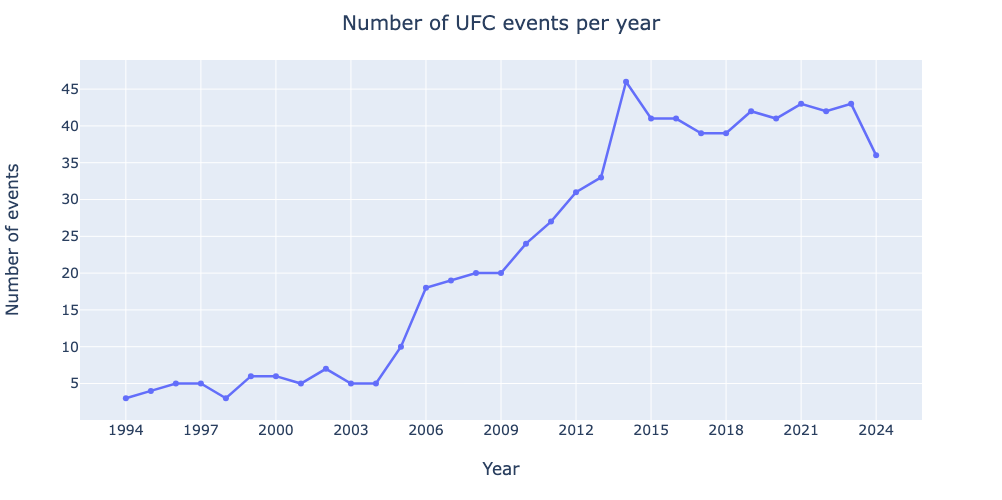

In [179]:
fig = px.line(events_annually_counts, x="event_year", y="num_of_events", markers=True)

# Cosmetics config
fig.update_layout(
    title={"text": "Number of UFC events per year", "x": 0.5, "font_size": 20},
    font={"size": 14},
    xaxis=dict(
        tick0=1994,  # this specifies the x axis tick to start from
        dtick=3,  # this specifies the step of x axis ticks
        title="Year",
        title_standoff=25,
    ),
    yaxis=dict(title="Number of events", title_standoff=40),
    height=500,
)

# Increase the width of the line
fig.update_traces(patch={"line": {"width": 2.5}})
fig.show()

### Observations

We can observe the following:
* The chart starts out with **initial steady growth** throughout `1995-2004`, with an average of 4 events;
* Then, the `2005-2010` era is where the UFC signed a **deal with Spike TV** to broadcast The Ultimate Fighter show. At the same time, the UFC started being taken as a legitimate sports property, shifting perception from the "human cockfighting" to "real sport" in a controlled, regulated environment. UFC starts expanding.
* In `2011-2014`, **UFC entered Brazil, Asia, and Europe** - showcased by a jump from 27 => 46 events.
* In `2015-2019`, there was a steady number of annual events, ~40 on average. **UFC signed a deal with ESPN**, became more structured, stable, and profitable.
* `2020-2021` is interesting, it's the **COVID era**, but UFC did well, **due to having built UFC Apex** (UFC's own custom facility that is adapted to hosting events, as well as a training facility) a year before in 2019, as well as **Abu Dhabi's built Fight Island**. This allows them to continue hosting events behind closed doors (no other league could do that).
* `2021-2024` shows how fast **UFC normalized their events**, where **Florida was the first state to allow them to continue hosting events.**
* `2024` is still going, so we're not going to draw any conclusions here just yet, but it's on track to hit the number of previous years.

## 3. What are the top fight outcomes?

### Preparing the data

Getting the data ready:

In [180]:
# Get the counts per every victory method
top_fight_outcomes = df["method"].value_counts()

# Extracting data
outcomes = top_fight_outcomes.index
counts = top_fight_outcomes.values

# Taking a peak
top_fight_outcomes

method
Decision - Unanimous       2793
KO/TKO                     2484
Submission                 1550
Decision - Split            750
TKO - Doctor's Stoppage      94
Decision - Majority          60
DQ                           23
Name: count, dtype: int64

Plotting it:

### Plotting

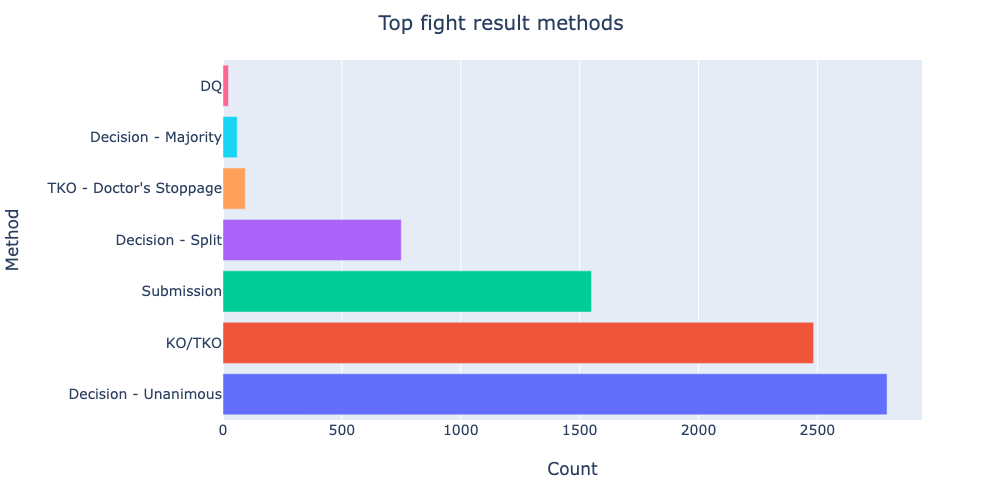

In [181]:
fig = px.bar(x=counts, y=outcomes, color=outcomes)

# Cosmetics config
fig.update_layout(
    title={"text": "Top fight result methods", "x": 0.5, "font_size": 20},
    font={"size": 14},
    xaxis=dict(title="Count", title_standoff=25),
    yaxis=dict(title="Method", title_standoff=40),
    showlegend=False,
    height=500,
)
fig.show()

### Observations

* `The top 1 result is a win by Decision - Unanimous`. The reason for that is that: 1 - it is **much harder to KO/TKO or submit an opponent** as it usually indicates a significant difference in expertise/level of fighters, and 2 - it is probably the fact that **a lot of the fighters like to "play safe"**, **avoid taking big risks**, **and just win by points**.
* `The top 2 are KO/TKO`, followed by submission at the top 3, which is just a grappler's way of KO/TKOing someone. KO/TKO is more common due to two reasons: 1 - **the fights, as well as each round, start in stand-up (from striking position)** and not from wrestling position, meaning **on average, fighters spend more time striking than grappling**, 2 - **There is more strikers than wrestlers** in the UFC roster, and potentially 3 - Fighters might, sometimes, **avoid wrestling** as the fans do not like it and say that it is "boring" and **prefer striking** instead.
* `At the top 4 - Decision - Split`, is when only 2 judges out of 3 gave the victory to the winner. Usually, **happens relatively more rarely**, as the judges are usually on the same page when it comes to a winner. But usually means that the winner **won on the edge**.
* `At top 5 - TKO Doctor's Stoppage` - the result, when a fighter is **deemed unfit** by a doctor or referee to continue to fight **due to an injury**, even less likely, because, usually, **small cuts or swellings** that could naturally happen during the fight are not deemed to unfit to continue, and it is marginally much rarer that a fighter sustained a significant injury and is not knocked out or submitted.
* `At top 6 - Decision - Majority`, almost the same as Decision - Split, but instead of the 2 out of 3 judges giving victory to the winner and the 3rd giving victory to the loser, in Majority Decision, the third judge scores the fight as draw. The majority decisions are **less common** because it is **harder statistically**, one fighter would have to be scored two 10-8 rounds and then the other fighter one 10-8 round in a 3-rd fight, which is rarer, or a round being scored 10-10 which is even less likely as judges are discouraged to do that, unless it is impossible to assign the winner of the round, even no slightest difference can be noted, or a combination of the factors above + point deductions, which happen in fewer than 2% of the fights.
* `At the top 7 - DQ`, DQ is disqualification, it **is the rarest**, as the fighters are usually very careful when it comes to the rules, and disqualification effectively **means loss**, so they'd rather try and win even if they're losing than outright lose.

## 4. Does being in a particular corner contribute to a victory?

### Preparing the data

Data:

In [182]:
# Sorting
winners_by_corner = df["winner"].value_counts()

# Converting into pct
winners_by_corner = winners_by_corner / sum(winners_by_corner) * 100

Let's plot:

### Plotting

In [183]:
winners_by_corner = pd.DataFrame(winners_by_corner).reset_index()
winners_by_corner

winner    count
0    red  65.0374
1   blue  34.9626

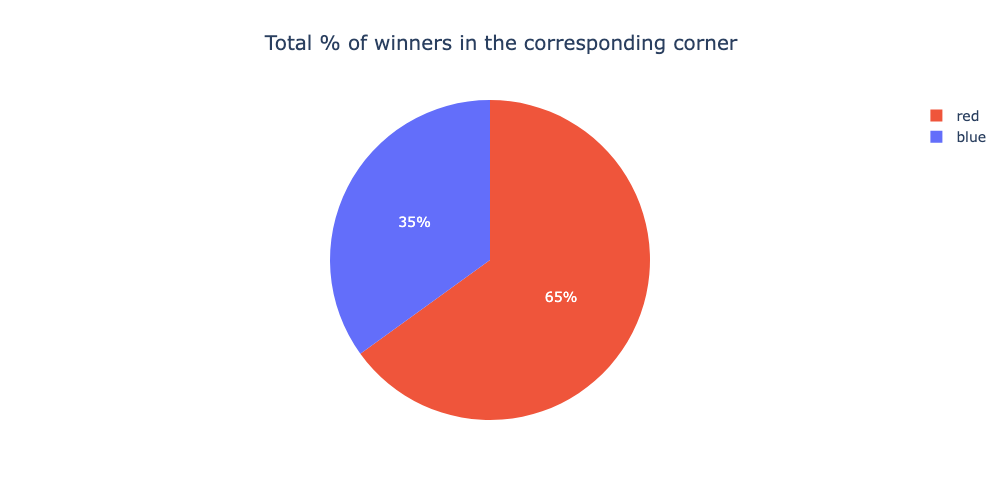

In [184]:
fig = px.pie(
    winners_by_corner,
    values="count",
    names="winner",
    title="Total % of winners in the corresponding corner",
    height=500,
    color="winner",
    color_discrete_map={"red": "EF553B", "blue": "636EFA"},
)

fig.update_layout(
    title={"x": 0.5, "font_size": 20},
    font={"size": 14},
)
fig.update_traces(textfont_size=14, textfont={"color": "white"})
fig.show()

### Observations

* `The red corner is the dominant one`, since it is **given to champions and higher-ranked fighters**.
* Where the `blue` is assigned to **lower-ranked fighters and title challengers**.

## 5. Does having a specific fighting stance contribute to a victory?

Now, let's take a look at whether fighting stance matters.

### Preparing the data

All possible stances:

In [185]:
set(df.winner_stance.unique().tolist() + df.loser_stance.unique().tolist())

{'Open Stance', 'Orthodox', 'Sideways', 'Southpaw', 'Switch', nan}

Let's drop the 0's:

In [186]:
cols = [["winner_stance", "loser_stance"]]
idxs = df[(df["winner_stance"] == "0") | (df["loser_stance"] == "0")].index

stances_df = df[["winner_stance", "loser_stance"]].drop(index=idxs).dropna()

In [187]:
stances_df["winner_stance"].value_counts()

winner_stance
Orthodox       4937
Southpaw       1416
Switch          315
Open Stance      13
Sideways          2
Name: count, dtype: int64

In [188]:
stances_df["loser_stance"].value_counts()

loser_stance
Orthodox       5101
Southpaw       1287
Switch          280
Open Stance      11
Sideways          4
Name: count, dtype: int64

Let's calculate win rate for each stance:

In [189]:
# Stances total
stances_total = (
    stances_df["winner_stance"]
    .value_counts()
    .add(stances_df["loser_stance"].value_counts(), fill_value=0)
)

# Stances win rate
stances_wr = (
    stances_df["winner_stance"].value_counts().div(stances_total, fill_value=0) * 100
).sort_values()
stances_wr

winner_stance
Sideways       33.333333
Orthodox       49.183104
Southpaw       52.386238
Switch         52.941176
Open Stance    54.166667
Name: count, dtype: float64

Good.

Let's examine the different stance matchups:

In [190]:
stances_df.value_counts()

winner_stance  loser_stance
Orthodox       Orthodox        3814
Southpaw       Orthodox        1056
Orthodox       Southpaw         917
Southpaw       Southpaw         295
Switch         Orthodox         220
Orthodox       Switch           196
Switch         Southpaw          72
Southpaw       Switch            61
Switch         Switch            23
Open Stance    Orthodox          10
Orthodox       Open Stance        7
Southpaw       Open Stance        3
Open Stance    Southpaw           3
Orthodox       Sideways           3
Southpaw       Sideways           1
Sideways       Open Stance        1
               Orthodox           1
Name: count, dtype: int64

In [191]:
# Pick rows, where the stances of both fighters are the same
samestance_idxs = stances_df[stances_df.winner_stance == stances_df.loser_stance].index

# Drop same stance matchups
stances_df.drop(index=samestance_idxs, inplace=True)

In [192]:
matchup_cnts = stances_df.value_counts().reset_index()
matchup_cnts

winner_stance loser_stance  count
0       Southpaw     Orthodox   1056
1       Orthodox     Southpaw    917
2         Switch     Orthodox    220
3       Orthodox       Switch    196
4         Switch     Southpaw     72
5       Southpaw       Switch     61
6    Open Stance     Orthodox     10
7       Orthodox  Open Stance      7
8    Open Stance     Southpaw      3
9       Orthodox     Sideways      3
10      Southpaw  Open Stance      3
11      Sideways  Open Stance      1
12      Sideways     Orthodox      1
13      Southpaw     Sideways      1

Normalize winner/loser_stance Southpaw:Orthodox and loser/winner_stance Orthodox:Southpaw into a single group Southpaw:Orthodox to get the total counts needed for ratio calculations:

In [193]:
stances_df["stance_pairs"] = stances_df.apply(
    lambda row: tuple(sorted([row["winner_stance"], row["loser_stance"]])), axis=1
)
stance_pairs_cnts = dict(stances_df["stance_pairs"].value_counts())
stance_pairs_cnts

{('Orthodox', 'Southpaw'): 1973,
 ('Orthodox', 'Switch'): 416,
 ('Southpaw', 'Switch'): 133,
 ('Open Stance', 'Orthodox'): 17,
 ('Open Stance', 'Southpaw'): 6,
 ('Orthodox', 'Sideways'): 4,
 ('Sideways', 'Southpaw'): 1,
 ('Open Stance', 'Sideways'): 1}

In [194]:
stances_df["stance_pairs_cnts"] = stances_df["stance_pairs"].apply(
    lambda val: stance_pairs_cnts[val]
)
stances_df.head()

winner_stance loser_stance          stance_pairs  stance_pairs_cnts
27        Switch     Orthodox    (Orthodox, Switch)                416
28      Southpaw     Orthodox  (Orthodox, Southpaw)               1973
38        Switch     Orthodox    (Orthodox, Switch)                416
41      Southpaw     Orthodox  (Orthodox, Southpaw)               1973
45      Orthodox     Southpaw  (Orthodox, Southpaw)               1973

In [195]:
matchup_cnt = pd.DataFrame(
    stances_df[["winner_stance", "loser_stance"]].value_counts()
).reset_index()
matchup_cnt

winner_stance loser_stance  count
0       Southpaw     Orthodox   1056
1       Orthodox     Southpaw    917
2         Switch     Orthodox    220
3       Orthodox       Switch    196
4         Switch     Southpaw     72
5       Southpaw       Switch     61
6    Open Stance     Orthodox     10
7       Orthodox  Open Stance      7
8    Open Stance     Southpaw      3
9       Orthodox     Sideways      3
10      Southpaw  Open Stance      3
11      Sideways  Open Stance      1
12      Sideways     Orthodox      1
13      Southpaw     Sideways      1

In [196]:
stances_df = stances_df.merge(
    matchup_cnt, how="left", on=["winner_stance", "loser_stance"]
).rename(columns={"count": "matchup_cnt"})
stances_df

winner_stance loser_stance             stance_pairs  stance_pairs_cnts  \
0           Switch     Orthodox       (Orthodox, Switch)                416   
1         Southpaw     Orthodox     (Orthodox, Southpaw)               1973   
2           Switch     Orthodox       (Orthodox, Switch)                416   
3         Southpaw     Orthodox     (Orthodox, Southpaw)               1973   
4         Orthodox     Southpaw     (Orthodox, Southpaw)               1973   
...            ...          ...                      ...                ...   
2546      Orthodox     Southpaw     (Orthodox, Southpaw)               1973   
2547      Sideways  Open Stance  (Open Stance, Sideways)                  1   
2548      Southpaw     Orthodox     (Orthodox, Southpaw)               1973   
2549      Orthodox     Southpaw     (Orthodox, Southpaw)               1973   
2550      Southpaw     Orthodox     (Orthodox, Southpaw)               1973   

      matchup_cnt  
0             220  
1            1056  
2             220  
3            1056  
4             917  
...           ...  
2546          917  
2547            1  
2548         1056  
2549          917  
2550         1056  

[2551 rows x 5 columns]

In [197]:
stances_df.drop_duplicates(subset=["loser_stance", "winner_stance"], inplace=True)

# Calc win rate
stances_df["stance_matchups_wr"] = (
    stances_df.matchup_cnt.div(stances_df.stance_pairs_cnts) * 100
).round(2)

# Drop now irrelevant cols for interpretability
stances_df = stances_df.loc[
    :, ["winner_stance", "loser_stance", "stance_matchups_wr", "matchup_cnt"]
]

In [198]:
stances_df

winner_stance loser_stance  stance_matchups_wr  matchup_cnt
0           Switch     Orthodox               52.88          220
1         Southpaw     Orthodox               53.52         1056
4         Orthodox     Southpaw               46.48          917
7         Orthodox       Switch               47.12          196
9         Southpaw       Switch               45.86           61
12          Switch     Southpaw               54.14           72
1941      Orthodox  Open Stance               41.18            7
1993   Open Stance     Southpaw               50.00            3
2114   Open Stance     Orthodox               58.82           10
2176      Southpaw  Open Stance               50.00            3
2367      Orthodox     Sideways               75.00            3
2540      Southpaw     Sideways              100.00            1
2542      Sideways     Orthodox               25.00            1
2547      Sideways  Open Stance              100.00            1

Leave only the stance matchups, where the number of recorded fights was > 5, in order to sort out the unrealistic high % pct winrates, for stances like 'Sideways' or 'Open Stance', which is very rare:

In [199]:
stances_df.sort_values(by="matchup_cnt").head(5)

winner_stance loser_stance  stance_matchups_wr  matchup_cnt
2540      Southpaw     Sideways               100.0            1
2542      Sideways     Orthodox                25.0            1
2547      Sideways  Open Stance               100.0            1
1993   Open Stance     Southpaw                50.0            3
2176      Southpaw  Open Stance                50.0            3

Filtering:

In [200]:
stances_df = stances_df[stances_df["matchup_cnt"] > 5]
stances_df

winner_stance loser_stance  stance_matchups_wr  matchup_cnt
0           Switch     Orthodox               52.88          220
1         Southpaw     Orthodox               53.52         1056
4         Orthodox     Southpaw               46.48          917
7         Orthodox       Switch               47.12          196
9         Southpaw       Switch               45.86           61
12          Switch     Southpaw               54.14           72
1941      Orthodox  Open Stance               41.18            7
2114   Open Stance     Orthodox               58.82           10

Pivoting to the expected by a heatmap format:

In [201]:
stances_df = stances_df.pivot(
    index="winner_stance", columns="loser_stance", values="stance_matchups_wr"
)
stances_df

loser_stance   Open Stance  Orthodox  Southpaw  Switch
winner_stance                                         
Open Stance            NaN     58.82       NaN     NaN
Orthodox             41.18       NaN     46.48   47.12
Southpaw               NaN     53.52       NaN   45.86
Switch                 NaN     52.88     54.14     NaN

### Plotting

Plotting now:

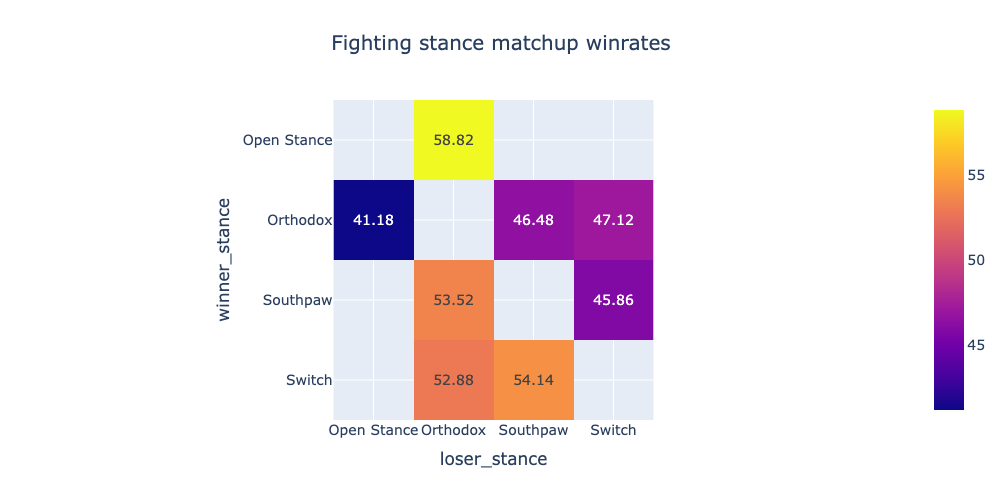

In [202]:
fig = px.imshow(
    stances_df, text_auto=True, height=500, title="Fighting stance matchup winrates"
)
fig.update_layout(
    title={"x": 0.5, "font_size": 20},
    font={"size": 14},
)
fig.show()

### Observations

* `Open Stance`, **the rarest fighting stance** out of all, is `ranked at #1`, having recorded only matchups against Orthodox (since it's so rare) with a win rate of 58.82% against the Orthodox stance;
* Followed by `Switch, ranked at #2`, having a winrate of **52.88%** against Orthodox and **54.14%** against Southpaw stance, with **no** recorded matchups against Open Stance;
* Followed `Southpaw, ranked at #3`, having a winrate of **53.52%** against Orthodox stance and **45.86%** against Switch, **no** matchups are recorded against Open Stance due to the rarity of the opposed fighting stance;
* `At #4`, there's the most common fighting stance - `Orthodox`, having recorded **41.18%** winrate against Open Stance, **46.48%** against Southpaw, and **47.12%** against Switch.

#### Interpretation

`Open Stance is #1`, but the **number of matchups** recorded for this stance is between **5-15**, so I wouldn't give too much weight to the data from this stance, as the sample size is just **too small**.

Other than that, **fighting is all about doing what you practiced**, and doing what you used to do, and so if you meet someone with a technique you're not used to, **it's a problem**. 
So, I think all of this comes down to **how rare the stance is**, and how uncomfortable it is to oppose someone with a style that you've rarely practiced against, and preparing for a fighter with a rare stance doesn't make it easier as well, as you have to find a sparring partner that has the same stance, and preferrably, even the same style, not even mentioning the height/weight/reach, etc. which is also **not an easy problem to solve**.

Very few fighters can have a good performance in both stances, i.e., being a Switch, since it's just too hard to be good in both of these, as I believe you have to put twice as much work as an Orthodox, or a Southpaw would have to do. That's why it's rare.

And **the other side is also true**, a fighter with a rare stance, say Switch, is very comfortable with fighting an Orthodox or Southpaw, because there are just **many more fighters with these stances**. But at the same time, it's also very hard to be on a high level in both stances, as again, you have to put twice as much work into being good at those to be able to compete with other "single-stance" fighters.

Then, as per <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC3834302/">this source</a>, the proportion of southpaw fighters versus orthodox fighters in the UFC is approximately **17.4% southpaws** and **80.3% orthodox**, with around **2.3% using other stances** (like switch or open stance).
So the same logic applies to **southpaws having a higher win rate than orthodox**.

But it's clearly **not the only factor that decides a victory**, that's not to say that a southpaw will beat an orthodox with 100% probability, no, **many more factors play a role in the outcome**, one of them is **the skill**, the other ones we will take a look at just now.

`Conclusion: Switch > Southpaw > Orthodox`

## 6. What are the main fighting aspects contributing to a victory?

### Multivariate analysis

#### Preparing the data

Let's now consider other aspects of the fight, such as the total number of significant strikes landed, the number of significant strikes landed by the target: to the head, body, leg; the number of significant strikes landed by position: distance, clinch, ground; takedown accuracy, submission attempts, reversals, fight control, etc.

In [203]:
# Parse all delta features
delta_feats = [f for f in df.columns if f.startswith("delta")]
delta_feats

['delta_KD',
 'delta_sig_str_pct',
 'delta_total_str_pct',
 'delta_TD_pct',
 'delta_sub_att',
 'delta_rev',
 'delta_ctrl',
 'delta_sig_str_head_acc_pct',
 'delta_sig_str_body_acc_pct',
 'delta_sig_str_leg_acc_pct',
 'delta_sig_str_distance_acc_pct',
 'delta_sig_str_clinch_acc_pct',
 'delta_sig_str_ground_acc_pct',
 'delta_sig_str_head_tar_pct',
 'delta_sig_str_body_tar_pct',
 'delta_sig_str_leg_tar_pct',
 'delta_sig_str_distance_pos_pct',
 'delta_sig_str_clinch_pos_pct',
 'delta_sig_str_ground_pos_pct',
 'delta_height',
 'delta_reach',
 'delta_slpm_cs',
 'delta_str_acc_cs',
 'delta_sapm_cs',
 'delta_str_def_cs',
 'delta_td_avg_cs',
 'delta_td_acc_cs',
 'delta_td_def_cs',
 'delta_sub_avg_cs']

##### Dropping NaNs

In [232]:
nans = df[delta_feats].isna().sum()
nans = pd.DataFrame(data={"feature": nans.index, "count": nans.values})
nans

feature  count
0                         delta_KD     21
1                delta_sig_str_pct      0
2              delta_total_str_pct     21
3                     delta_TD_pct      0
4                    delta_sub_att     21
5                        delta_rev     21
6                       delta_ctrl    199
7       delta_sig_str_head_acc_pct     21
8       delta_sig_str_body_acc_pct     21
9        delta_sig_str_leg_acc_pct     21
10  delta_sig_str_distance_acc_pct     21
11    delta_sig_str_clinch_acc_pct     21
12    delta_sig_str_ground_acc_pct     21
13      delta_sig_str_head_tar_pct     21
14      delta_sig_str_body_tar_pct     21
15       delta_sig_str_leg_tar_pct     21
16  delta_sig_str_distance_pos_pct     21
17    delta_sig_str_clinch_pos_pct     21
18    delta_sig_str_ground_pos_pct     21
19                    delta_height    941
20                     delta_reach   2049
21                   delta_slpm_cs    905
22                delta_str_acc_cs    905
23                   delta_sapm_cs    905
24                delta_str_def_cs    905
25                 delta_td_avg_cs    905
26                 delta_td_acc_cs    905
27                 delta_td_def_cs    905
28                delta_sub_avg_cs    905

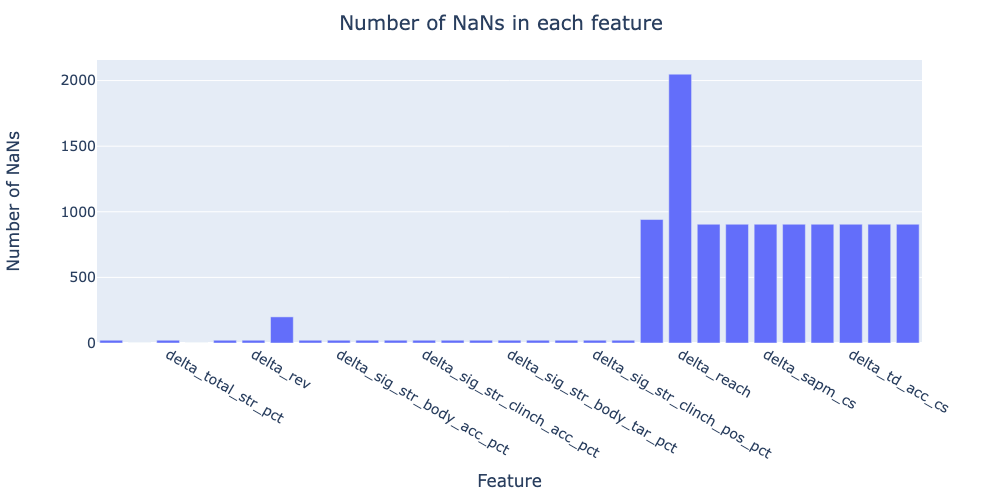

In [243]:
fig = px.bar(nans, x='feature', y='count', text_auto='.2s')

# Cosmetics config
fig.update_layout(
    title={"text": "Number of NaNs in each feature", "x": 0.5, "font_size": 20},
    font={"size": 14},
    xaxis=dict(
        tick0=1994,  # this specifies the x axis tick to start from
        dtick=3,  # this specifies the step of x axis ticks
        title="Feature",
        title_standoff=25,
    ),
    yaxis=dict(title="Number of NaNs", title_standoff=40),
    height=500,
    #xaxis_tickangle=-90
)

# Increase the width of the line
#fig.update_traces(patch={"line": {"width": 2.5}})
fig.show()

In [146]:
# Shape before
before = df.shape

df = df.dropna(subset=delta_feats)

# Before vs After
before, df.shape

((7754, 42), (5700, 42))

In [147]:
df[delta_feats].isna().sum()

delta_KD                          0
delta_sig_str_pct                 0
delta_total_str_pct               0
delta_TD_pct                      0
delta_sub_att                     0
delta_rev                         0
delta_ctrl                        0
delta_sig_str_head_acc_pct        0
delta_sig_str_body_acc_pct        0
delta_sig_str_leg_acc_pct         0
delta_sig_str_distance_acc_pct    0
delta_sig_str_clinch_acc_pct      0
delta_sig_str_ground_acc_pct      0
delta_sig_str_head_tar_pct        0
delta_sig_str_body_tar_pct        0
delta_sig_str_leg_tar_pct         0
delta_sig_str_distance_pos_pct    0
delta_sig_str_clinch_pos_pct      0
delta_sig_str_ground_pos_pct      0
delta_height                      0
delta_reach                       0
delta_slpm_cs                     0
delta_str_acc_cs                  0
delta_sapm_cs                     0
delta_str_def_cs                  0
delta_td_avg_cs                   0
delta_td_acc_cs                   0
delta_td_def_cs             

#### Boxplots

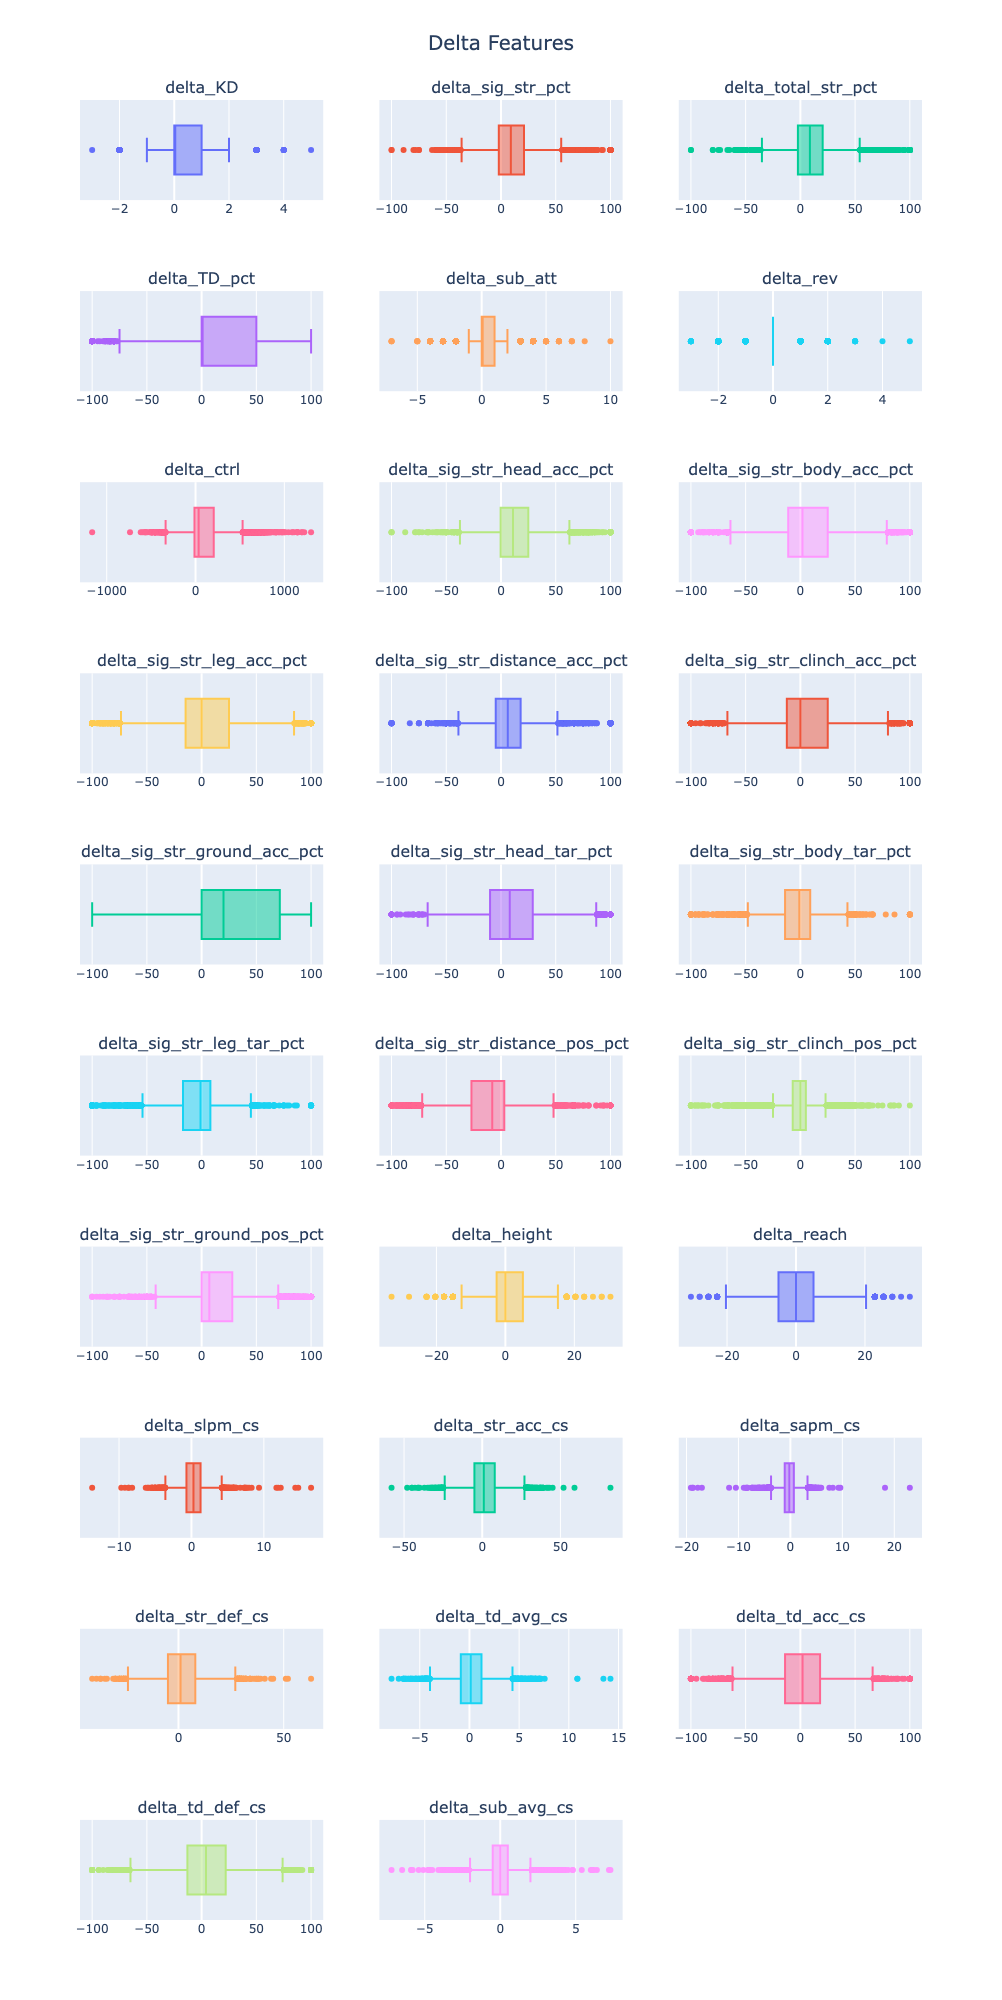

In [148]:
ROWS, COLS = 10, 3

fig = make_subplots(rows=ROWS, cols=COLS,
                   subplot_titles=delta_feats)

fig.add_traces(
    [go.Box(x=df[f]) for f in delta_feats],
    rows=[1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10],
    cols=[1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2]
)

fig.update_yaxes(showticklabels=False)
fig.update_layout(height=2000, width=1000, showlegend=False, title={"text": "Delta Features",
                                                                    "x": 0.5, "font_size": 20})
fig.show()

##### Observations

**None** of the features **except** `delta_rev` and maybe `delta_sub_att` have a very **small sample size**, so let's try to rank these features and zoom in on some of them in just a bit to get a closer look.

#### Cohen's D

##### Preparing the data

For better interpretability, let's do the `Cohen's D` test on these features. It will assist us in ranking the features, by looking at the signal-to-noise ratio, and the nice property of Cohen's D is that it measures the **standardized effect**, which comes in handy in our case, because we **have features** that are on **different scales**, some of them are in percentages, some in seconds, which would be ranked as the top features due to the scale difference only.

Since we've already transformed both populations of every single feature into their delta versions, we're going to run the test as a single group against the mean of 0:

In [149]:
cohensd = (df[delta_feats].mean() - 0) / df[delta_feats].std()

d_df = pd.DataFrame(data={"d": np.round(cohensd, 2)})
d_df.sort_values(by="d", ascending=False)

d
delta_sig_str_head_acc_pct      0.59
delta_sig_str_ground_pos_pct    0.56
delta_sig_str_ground_acc_pct    0.52
delta_sig_str_pct               0.51
delta_total_str_pct             0.50
delta_KD                        0.47
delta_ctrl                      0.44
delta_sig_str_head_tar_pct      0.34
delta_TD_pct                    0.33
delta_sig_str_distance_acc_pct  0.32
delta_sub_att                   0.25
delta_sig_str_body_acc_pct      0.20
delta_slpm_cs                   0.18
delta_str_def_cs                0.17
delta_sig_str_clinch_acc_pct    0.15
delta_str_acc_cs                0.15
delta_td_def_cs                 0.14
delta_td_avg_cs                 0.11
delta_td_acc_cs                 0.08
delta_sig_str_leg_acc_pct       0.08
delta_reach                     0.07
delta_height                    0.04
delta_rev                       0.04
delta_sub_avg_cs                0.02
delta_sig_str_clinch_pos_pct   -0.10
delta_sapm_cs                  -0.15
delta_sig_str_body_tar_pct     -0.18
delta_sig_str_leg_tar_pct      -0.21
delta_sig_str_distance_pos_pct -0.43

The way to interpret these D values is as follows:

In [150]:
pd.DataFrame(
    data={"Cohen’s d": [0.2, 0.5, 0.8], "Effect Size": ["Small", "Medium", "Large"]}
)

Cohen’s d Effect Size
0        0.2       Small
1        0.5      Medium
2        0.8       Large

The same for negative values. So a D value of 0.5 would indicate that there's a medium contribution of that feature to winning, a D value of -0.5 would hint at a medium contribution to losing, etc.

##### Plotting

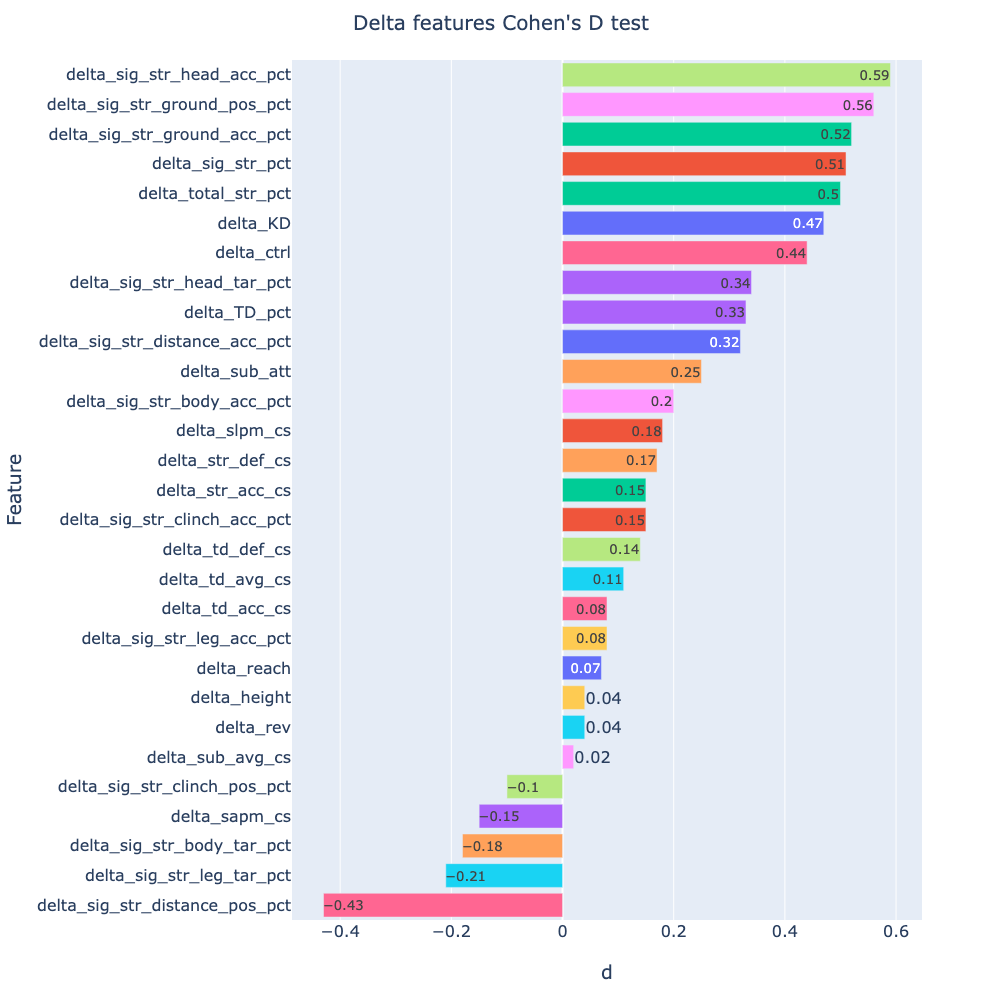

In [151]:
fig = px.bar(d_df, x="d", y=d_df.index, color=d_df.index, text_auto=True)

# Cosmetics config
fig.update_layout(
    title={"text": "Delta features Cohen's D test", "x": 0.5, "font_size": 20},
    font={"size": 16},
    xaxis=dict(
        title="d",
        title_standoff=25,
    ),
    yaxis=dict(title="Feature", title_standoff=40, categoryorder="total ascending"),
    showlegend=False,
    height=1000,
)
fig.show()

##### Observations

`The most important features` that contribute to winning:

    Accuracy of significant strikes to the head, (this one seems to be very important) accuracy and position of significant strikes on the ground (vs clinch or distance), number of significant strikes landed, number of total strikes landed, number of knockdowns landed, control time, target of significant strikes to the head (vs body or leg), number of takedowns landed, accuracy of significant strikes landed from distance position (vs ground or clinch)

`Not as important features`, but they still do contribute to winning:

    Number of submission attempts, accuracy of significant strikes to the body (vs head or leg), career statistic of significant strikes landed per minute, cs of significant strike defence (the % of opponents' strikes that did not land), cs of sig. str. accuracy, accuracy of significant strikes in clinch position (vs ground or distance), cs of takedown defence.

Features that `barely contribute` to winning/are in the grey area:

    cs of avg. Number of takedowns landed per 15 min., accuracy of sig. str. to the legs, cs of takedown accuracy, fighter's reach, fighter's height, number of reversals, cs of average submissions attempted per 15 minutes.

Features that `negatively contribute to winning, i.e., contribute to losing`:

    Sig. str. landed from distance position (vs ground or clinch), target of sig. str. being leg (vs head or body), target of sig. str. being body (vs head or leg), cs significant strikes absorbed per minute, sig. str. from clinch position (vs ground or distance).

### Closer look

Now, let's take a closer look at some of the features and try and break it down why one features contribute to winning vs the other similar counterparts.

In [152]:
def plot_subplots(features, title):
    """Plots histograms of features in subplots and barchart of medians of these features"""
    ROWS, COLS = 1, 3

    # Init subplots
    hist_fig = make_subplots(rows=ROWS, cols=COLS, subplot_titles=features)

    # Adds a trace
    hist_fig.add_traces(
        [go.Histogram(x=df[f]) for f in features], rows=[1, 1, 1], cols=[1, 2, 3]
    )

    # Cosmetics
    hist_fig.update_yaxes(showticklabels=False)
    hist_fig.update_layout(
        height=300,
        width=1000,
        showlegend=False,
        title={"text": title, "x": 0.5, "font_size": 20},
    )
    hist_fig.show()

    # Plot medians for these features as well
    plot_medians(features)


def plot_medians(features):
    """Plots medians as a bar plot"""
    # Prep data
    medians = np.round(df[features].median(), 2)

    # Plot
    med_fig = px.bar(
        y=medians,
        x=df[features].median().index,
        color=df[features].median().index,
        text_auto=True,
    )
    
    # Cosmetics
    med_fig.update_yaxes(
        showticklabels=True, title="Value", tickfont_size=14, title_font_size=16
    )
    med_fig.update_xaxes(
        showticklabels=True, title="Feature", tickfont_size=14, title_font_size=16
    )
    med_fig.update_layout(
        height=200,
        width=1000,
        showlegend=False,
        title={"text": "Medians", "x": 0.5, "font_size": 20},
    )
    med_fig.show()

#### Accuracy of sig. str. to the head/body/legs

##### Plotting

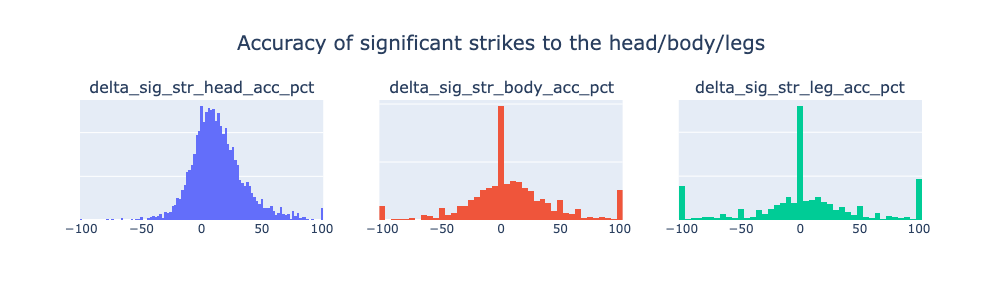

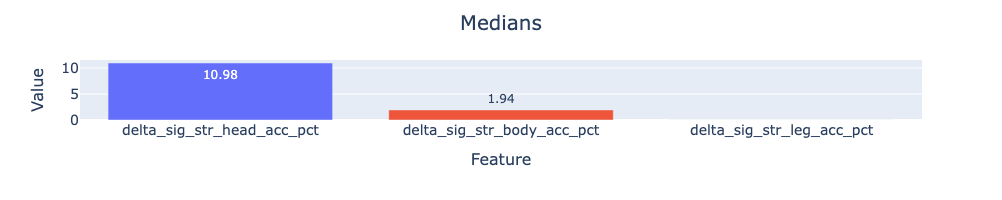

In [153]:
feats = [
    "delta_sig_str_head_acc_pct",
    "delta_sig_str_body_acc_pct",
    "delta_sig_str_leg_acc_pct",
]

plot_subplots(feats, "Accuracy of significant strikes to the head/body/legs")

##### Observations

* Body and legs distributions are more symmetrical, with tons of 0's in the middle, head is slightly skewed to the right with less noise in the 0 region.
* Medians as follows: head at 10.9, body at 1.9, and legs at 0.

##### Interpretation

**Winners prefer** going for and **being more accurate with their strikes on the head** > body > legs. 
The head histogram shows some skewness to the right, which points at the fact that winners slightly tend to outperform losers in that regard, also the head being stable in the 0 area compared to the other two hints at the fact how these features are calculated, they're calculated with accuracy/attempts, and when attempts are 0, the accuracy will be 0 as well thus adding a huge candle in the 0 tick on body and legs charts. 

Median is the highest for head largely because it's the cleanest distribution, whereas in the other 2 the big 0 candle "eats the median away into 0".

Accurate sig. str. to the head hint on being important in winning, followed by sig. str. to the body having a smaller importance, ending with strikes to the legs showing no significant connection to winning.

But **accuracy alone is not a reliable predictor of winning** in fights, as a fighter may not be better on accuracy and instead, win on volume.

**Conclusion: `Head` > `body` > `legs`**

#### Distribution of sig. str. to the head/body/legs

##### Plotting

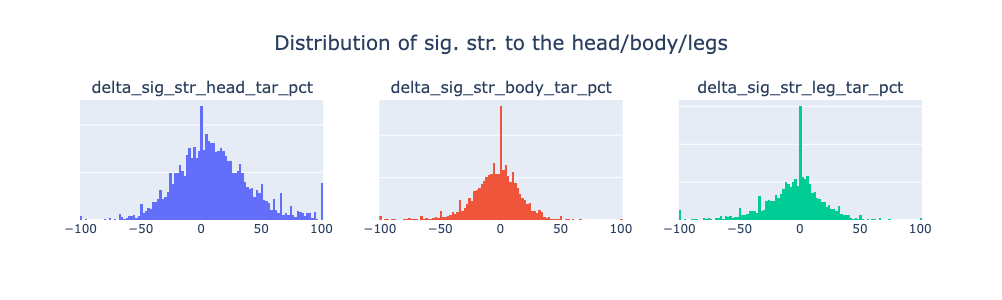

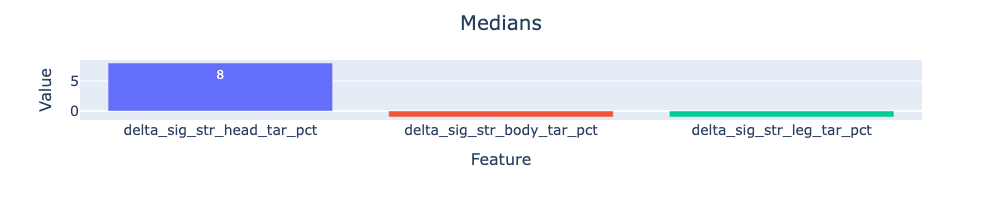

In [154]:
feats = [
    "delta_sig_str_head_tar_pct",
    "delta_sig_str_body_tar_pct",
    "delta_sig_str_leg_tar_pct",
]

plot_subplots(feats, "Distribution of sig. str. to the head/body/legs")

##### Observations

* Pretty similar situation, body and legs being slightly more symmetrical without showing any noticeable skewness to any of the sides, whereas the head shows a positive tail.
* Same situation as before with the 0 tick, head displays being more stable in that region, while body and legs have a big candle, the type of candle you'd like to see on a meme coin you hold. But, as was said before, a big part of it is just no punches being thrown to the body/legs, as a lot of the UFC fighters only go for the head. But the other reason this is true is because of the way this feature is calculated. It's calculated as the distribution of the sig. str. the fighter landed, so if there were 40 strikes landed to the body and 20 to the head. That's 33% for the head and 66% for the body. But say, as the rounds went by, the stats are now 60 to the head and 45 to the body. That's now 57% for the head and only 43% for the body. So, adding to one is in some way subtracting from another in this sense.
* Even though no noticeable skewness is visible on the body and legs plots, it's visible that the body and legs have slightly more outliers on the negative side, whereas the contrary is true for the head.
* Medians: 8 for the head, -1 for both body and legs.


##### Interpretation

**Winners prefer targeting their significant strikes to the head** > body = legs. 
Only the head has a positive median, positive skewness, and more outliers on the positive end, it is also more stable in the 0 region, whereas the body and legs have negative median, are symmetrical and slightly more outliers in the negative tail.

Thus, **head targeting is the key differentiator for winning**, whereas sig. str. to the body/legs seem to be less important but nonetheless, it's not like winners don't go for these targets, we can see in the num. of outliers; So they still are valuable, but yield value rather in the long run, on the other hand, head strikes are more visible, lead to cuts, thus showing significant damage, sway judges, and lead to KDs / finishes.

**Conclusion: `Head` > `body` = `legs`**

#### Accuracy of sig. str. landed in ground/clinch/distance position

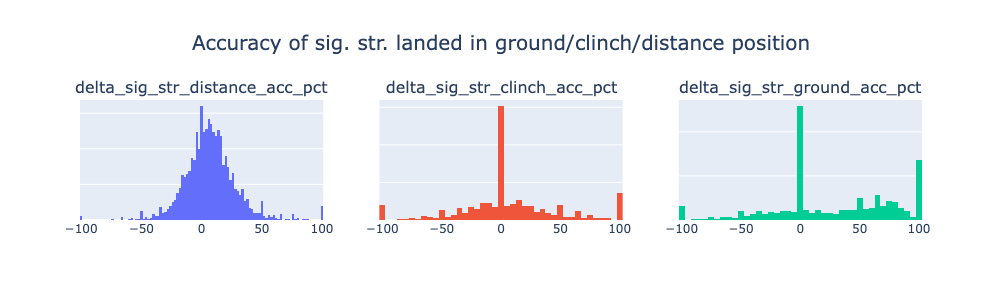

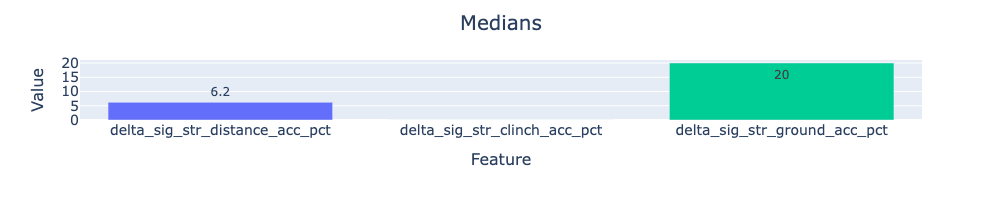

In [155]:
feats = [
    "delta_sig_str_distance_acc_pct",
    "delta_sig_str_clinch_acc_pct",
    "delta_sig_str_ground_acc_pct",
]

plot_subplots(feats, "Accuracy of sig. str. landed in ground/clinch/distance position")

##### Observations

* The distance is the most normally distributed, being the most stable in the 0 range, being slightly skewed to the right, having slightly more outliers on the positive end, and having a median of 6.
* Clinch has the biggest tick 0 candle, being about symmetrical, having slightly more outliers in the positive tail, and having a median of 0.
* Ground has a pretty big 0 candle as well, is definitely skewed to the right, having more outliers in the positive tail, and having a median of 20.

##### Interpretation

Accurate sig. str. landed in the ground position seems to be the biggest differentiator, due to the highest median, clear positive skew, and the outstanding number of positive outliers. Followed by strikes from distance, with still a positive median, normal distribution, and more outliers in the positive tail. **Accuracy in sig. str. from clinch position do not seem to contribute much**, 0 median, a bunch of noise, huge 0 tick hinting at clinching being relatively unpopular in fights, and having slightly more outliers in the positive tail.

This distribution makes sense, since, for distance, all fighters train striking from it, clinch depends on the style (Muay Thai or Wrestling), and then ground distribution makes sense, since whenever a grappler takes his opponent down, there's not much their opponent can do in the bottom position in terms of striking defense, so the difference in that position will be totally one-sided (also interesting note that if a fighter did not even throw any strikes on the ground, they will still get accuracy of 0%, thus adding to what we can observe above.)

Thus, **accurate significant strikes from the ground clearly contribute the most to winning**, whereas **accurate sig. str. from distance contributes as well, but not on the same scale**, and clinch does not seem to stand out in terms of a strategy for winning.

**Conclusion: `Ground` > `distance` > `clinch`**

#### Distribution of sig. str. landed in ground/clinch/distance position

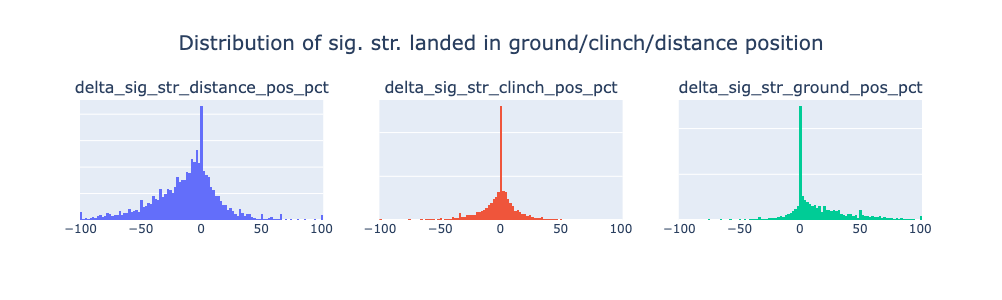

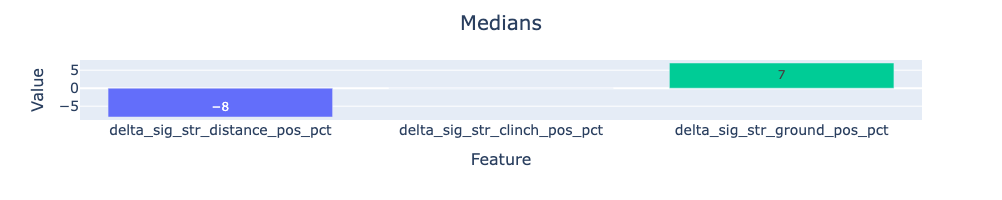

In [156]:
feats = [
    "delta_sig_str_distance_pos_pct",
    "delta_sig_str_clinch_pos_pct",
    "delta_sig_str_ground_pos_pct",
]

plot_subplots(
    feats, "Distribution of sig. str. landed in ground/clinch/distance position"
)

##### Observations

* The distance is negatively skewed, having about equal number of outliers on both ends, and having median of -8.
* The clinch is about normally distributed, having a huge wick at the 0 tick, not a significant number of outliers on both ends, and median of 0.
* The ground is positively skewed, having a big 0 tick as well, having slightly more outliers in the positive tail and having a median of 7.

##### Interpretation

Again, **sig. str. from the ground position contribute the most to winning**, thus further adding to the consensus between experts and fans that "on avg., wrestlers beat strikers".

The picture changes quite a bit for this feature, even though it's similar to the previous one. But a few things contribute to this change:
1. As was previously explained, the way this feature is calculated as it's just a distribution across strikes from 3 positions, and how it can "eat away the other features"
2. 99.9% of the fighters strike from a distance, but a much lower amount of fighters strike from the other positions, e.g., ground, as there are many fewer wrestlers than strikers, thus adding to this picture.
3. Winners just usually like to strike from the ground or clinch, as it's just much safer and the environment is much more controlled (at least in the ground position).

**Conclusion: `Ground` > `clinch` > `distance`**

#### Defense-based features

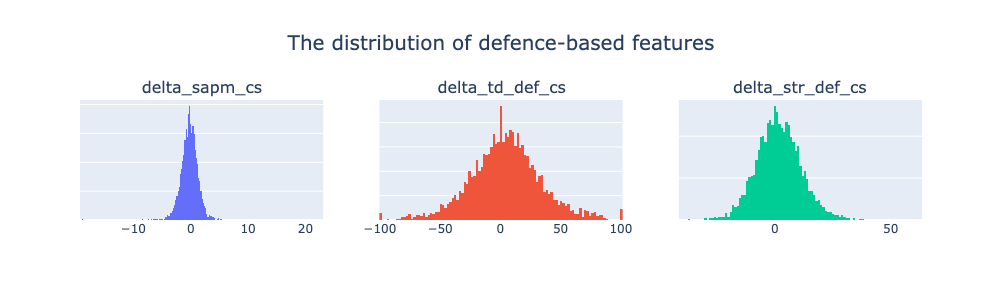

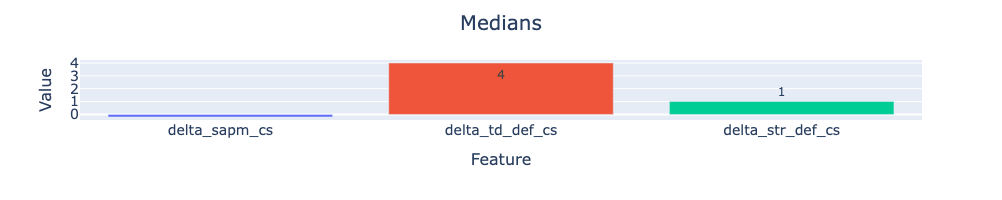

In [157]:
features = ["delta_sapm_cs", "delta_td_def_cs", "delta_str_def_cs"]

plot_subplots(
    ["delta_sapm_cs", "delta_td_def_cs", "delta_str_def_cs"],
    "The distribution of defence-based features",
)

##### Observations (the scales are different, so we have to be careful here):

* Bell-shaped distribution for sapm, slightly longer tail to the right, and slightly more outliers on the left, having median of -0.2.
* Normal distribution for takedown defense carreer statistic, centered slightly more positively from 0, having sligtly more outliers in the positive tail, and having median of 4.
* Slight positive skewness for striking defense career statistic, centered about at 0, having median of 1.

##### Interpretation

This is an interesting one, because `SAPM is the Significant Strikes Absorbed per Minute`, which means the amount of damage the fighter receives per minute, i.e., **the lower the better**, as opposed to the rest of the delta features. And even though the median is ~ 0, the number of outliers on the negative tail seems to be slightly bigger than on the positive tail, potentially indicating that winners might win slightly more with a lower `sapm_cs` value. But this is not definitive, as most of the fights end in a stance, and not on the ground, and the #1 fight outcome is a win by decision, thus probably making it a close fight and leading to both fighters absorbing punches.

**Takedown defense is the priority here**, as it has the biggest median, and usually people that wrestle have the best takedown defense, so I am not surprised here that this correlates to winning say more than striking defense, which even though has some positive skewness, but it's still centered at 0, so this doesn't seem to be a strong signal for winning in this case.

**Conclusion: `td_def` > `str_def` > `sapm_cs`**

## 7. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?

### Plotting

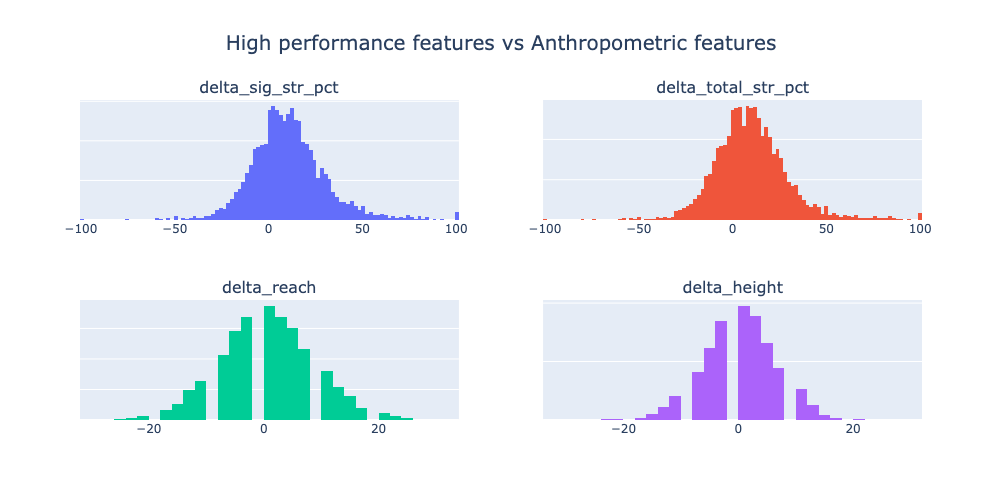

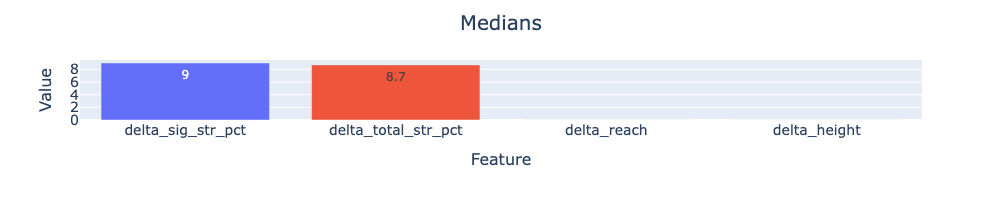

In [159]:
ROWS, COLS = 2, 2

features = ["delta_sig_str_pct", "delta_total_str_pct",
            "delta_reach", "delta_height"]

fig = make_subplots(rows=ROWS, cols=COLS,
                   subplot_titles=features)

fig.add_traces(
    [go.Histogram(x=df[f]) for f in features],
    rows=[1,1,2,2],
    cols=[1,2,1,2,]
)

fig.update_yaxes(showticklabels=False)
fig.update_layout(height=500, width=1000, showlegend=False,
                  title={"text": "High performance features vs Anthropometric features",
                         "x":0.5, "font_size": 20})

fig.show()

# Plot medians for these features as well
plot_medians(features)

### Observations (the scales are different, so we have to be careful here):

* Distribution is roughly normal for significant strikes, slight right skew, more outliers on the positive tail, median of 9
* Distribution is also roughly normal for total strikes, a bit right-skewed, with more outliers on the positive tail  median is also about 9
* The distribution is very centered at 0 for reach, no noticeable skew, about the same number of outliers, and a median of 0
* Height is very similar to the reach, centered at 0, no skew, similar outliers, median of 0

### Interpretation

We can clearly see that the skewness, positively centered distributions, an outstanding number of outliers, and outstanding medians clearly show us that landing more total strikes and landing more significant strikes contribute to winning.

Whereas **anthropometric features** like reach and height are neutral on average and **do not add a clear advantage to a fighter**, except in some matchups. For example in striking matchups, usually the consensus is, that a good tall fighter, or a good fighter with longer reach beats good shorter fighter, or good fighter with shorter reach, but it's MMA, and not only striking, and for example wrestlers, that are usually shorter by height and that have shorter reach that beat strikers offset this distribution to go back to 0.

**Conclusion: `sig_str` = `total_str` > `reach` = `height`**

# Answering questions

## Questions

1. What are the most popular locations where UFC hosts its events?
2. What is the historical average number of UFC events hosted annually?
3. What are the top fight outcomes?
4. Does being in a particular corner contribute to a victory?
5. Does having a specific fighting stance contribute to a victory?
6. What are the main fight tactics contributing to a victory?
7. Do any specific anthropometric features (like height, reach, etc.) contribute to a victory?
8. Based on the findings, can we use the information to bet on a fighter?

## Answers

1. The homeland to the UFC - The United States of America, is the #1 country where UFC hosts its events, taking 70.8% of the total pool of countries UFC events were run in. Followed by Brazil, Canada, the UK, the UAE, Australia, Japan, Mexico, Germany, and others.

    And in terms of the US states, Nevada is #1, taking 48.8% of the total pool of the distribution of the US States, where UFC hosts it's events. Followed by California, Texas, Florida, New York, Colorado, Louisiana, Illinois, and others.

2. Initially, from 1994 - 2004 there were around 4 events on average;
   Then, from 2005 till its peak in 2014 there was rapid growth with an average annual increase of 3.6 events;
   Which followed by a small drop of 5 events in 2015, after which it was in a relative plateau with fluctuations of 2-3 events on average;
   Ends with 2024, which is not finished yet, but is on track to fit in with the latest trend.

3. Top fight outcomes are (in descending order): Decision - Unanimous, KO/TKO, Submission, Decision - split, TKO - Doctor's Stoppage, Decision - Majority, DQ.

4. 65% of all victories are coming from the fighters in the red corner, and the remaining 35% are coming from the blue corner fighters.
This happens due to how fighters are assigned a certain corner, red corner is given to the champions defending their title, and also red corners are given to the higher-ranked fighters.

5. The stances with the highest winrates are as follows: Switch, Southpaw, Orthodox. Open Stance has too small of a sample size to reliably draw any conclusions from.

6. Tactics that contribute the most to winning are: landing sig. str. from ground position rather than distance or clinch, landing accurate sig. str. from ground position, rather than distance or clinch, having a high fight control time, landing accurate sig. str. to the head rather than to the body or legs, landing targeted sig. str. to the head rather than to the body or legs, outperforming on volume of total strikes, landed significant strikes, knockdowns, takedowns.

7. Anthropometric features do not seem to have any correlation on winning. They are purely matchup based.

8. Note: MMA is very matchup-based sport, and there's no one single feature, that would 100% lead to victories.

   That said, I think there's definitely something we can use from this to test the performance in betting. Specifically, I would be looking at fighters that are - wrestlers, they prefer to take the fight into a much more controlled environment - ground, and just land clean, easy to hit the target strikes, by the way, which also gains them control time, in addition, they usually have the best takedown defense, which will help them end up in the most one-sided position in the sport in the first place, I also would be looking for fighters that not necessarily land any strikes to the body or legs, but more so they focus on the head as the highest priority, which wins fights, leads to cuts, sways judges, triggers KOs, etc.

    At the same time, the reverse is true, I would not be betting on a fighter that only strikes from the distance position, doesn't have any wrestling skills, (it's not like fighters that do not have wresling skills do not win fights, e.g. a matchup of two strikers would obviously end up in a striker winning, and a poor wrestler would likely lose to a very good striker), prefers to largely strike to the body/legs and not the head, which would lead to a small amount of takedowns, knockdowns, cuts dealt, control time gained, and just when a judge sees a fighter visually not looking dominant (how a wrestler on a top position, fighter that has elite boxing skills) would look like.


**Conclusion: `Wrestling-based skills`> `Boxing skills` > `BJJ skills` > `Kickboxing/Muay Thai/Karate skills`**